In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from matplotlib.colors import LogNorm

In [2]:
from beeradvocate_loader import BeerAdvocateDataLoader

data_loader = BeerAdvocateDataLoader(data_dir="../ADA_project/data/BeerAdvocate", force_process=False)

ba_reviews_df, ba_ratings_df, ba_beers_df, ba_breweries_df, ba_users_df = data_loader.load_all_data()

print("Reviews DataFrame:")
print(ba_reviews_df.head())

print("\nRatings DataFrame:")
print(ba_ratings_df.head())

print("\nBeers DataFrame:")
print(ba_beers_df.head())

print("\nBreweries DataFrame:")
print(ba_breweries_df.head())

print("\nUsers DataFrame:")
print(ba_users_df.head())

Processed file '../ADA_project/data/BeerAdvocate\reviews_processed.csv' already exists. Skipping processing.
Processed file '../ADA_project/data/BeerAdvocate\ratings_processed.csv' already exists. Skipping processing.
Reviews DataFrame:
       beer_name  beer_id                               brewery_name  \
0          Régab   142544  Societe des Brasseries du Gabon (SOBRAGA)   
1  Barelegs Brew    19590       Strangford Lough Brewing Company Ltd   
2  Barelegs Brew    19590       Strangford Lough Brewing Company Ltd   
3  Barelegs Brew    19590       Strangford Lough Brewing Company Ltd   
4  Barelegs Brew    19590       Strangford Lough Brewing Company Ltd   

   brewery_id             style  abv        date        user_name  \
0       37262   Euro Pale Lager  4.5  1440064800          nmann08   
1       10093  English Pale Ale  4.5  1235127600      StJamesGate   
2       10093  English Pale Ale  4.5  1142247600          mdagnew   
3       10093  English Pale Ale  4.5  1101898800  hell

**First question to ask: what is the ditribution of reviewers accross countries?**

             cleaned_location  nbr_ratings
137  United States of America      7303870
28                     Canada       274512
136            United Kingdom        41597
11                  Australia        34915
123                    Sweden        29914
90                Netherlands        22952
50                    Germany        17460
106                   Romania        16823
16                    Belgium        16478
107                    Russia        10521


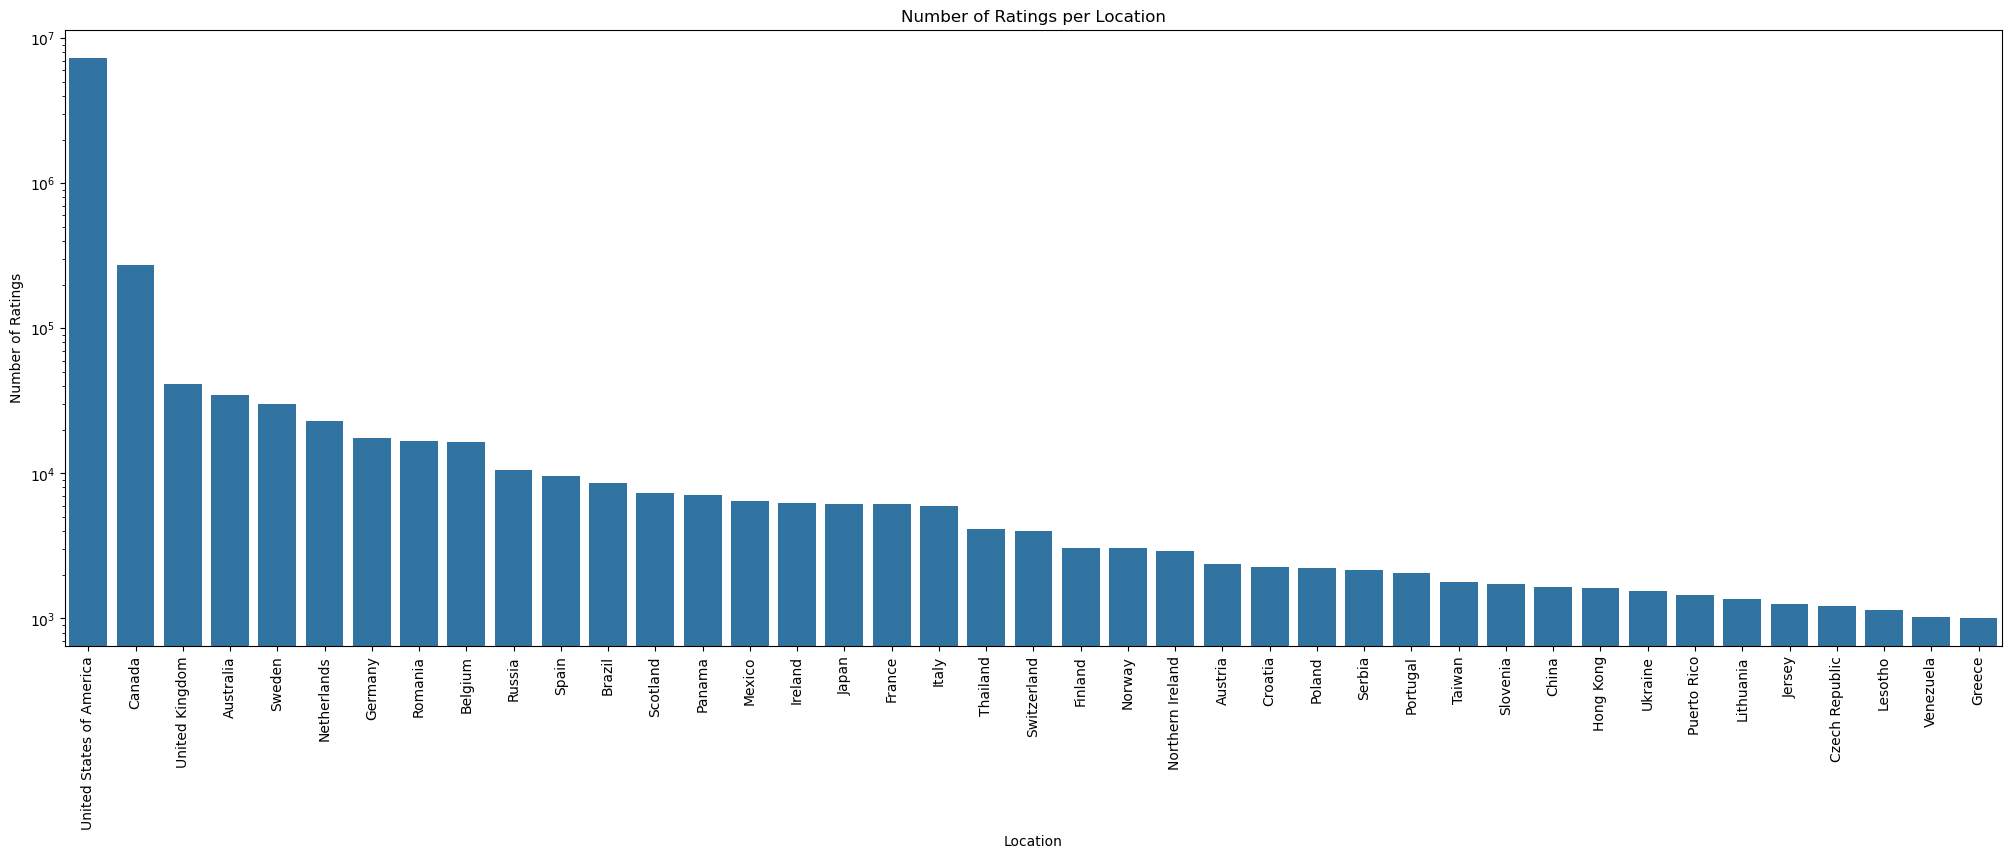

In [3]:
def clean_location(location):
    # Handle NaN values
    if isinstance(location, str):  # Check if location is a string
        country = location.split(',')[0].strip()
        # Replace "United States" with "United States of America"
        if country == "United States":
            return "United States of America"
        if country == "England":
            return "United Kingdom"
        return country
    return None

# Apply the cleanup function
ba_users_df['cleaned_location'] = ba_users_df['location'].apply(clean_location)
nbr_ratings_per_location = ba_users_df.groupby('cleaned_location')['nbr_ratings'].sum().reset_index()
nbr_ratings_per_location = nbr_ratings_per_location[nbr_ratings_per_location['nbr_ratings'] > 1000].sort_values(by='nbr_ratings', ascending=False)

print(nbr_ratings_per_location.head(10))
plt.figure(figsize=(25, 8))
sns.barplot(data=nbr_ratings_per_location, x='cleaned_location', y='nbr_ratings', log=True)
plt.title('Number of Ratings per Location')
plt.xlabel('Location')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)  # Rotate location names vertically
plt.show()

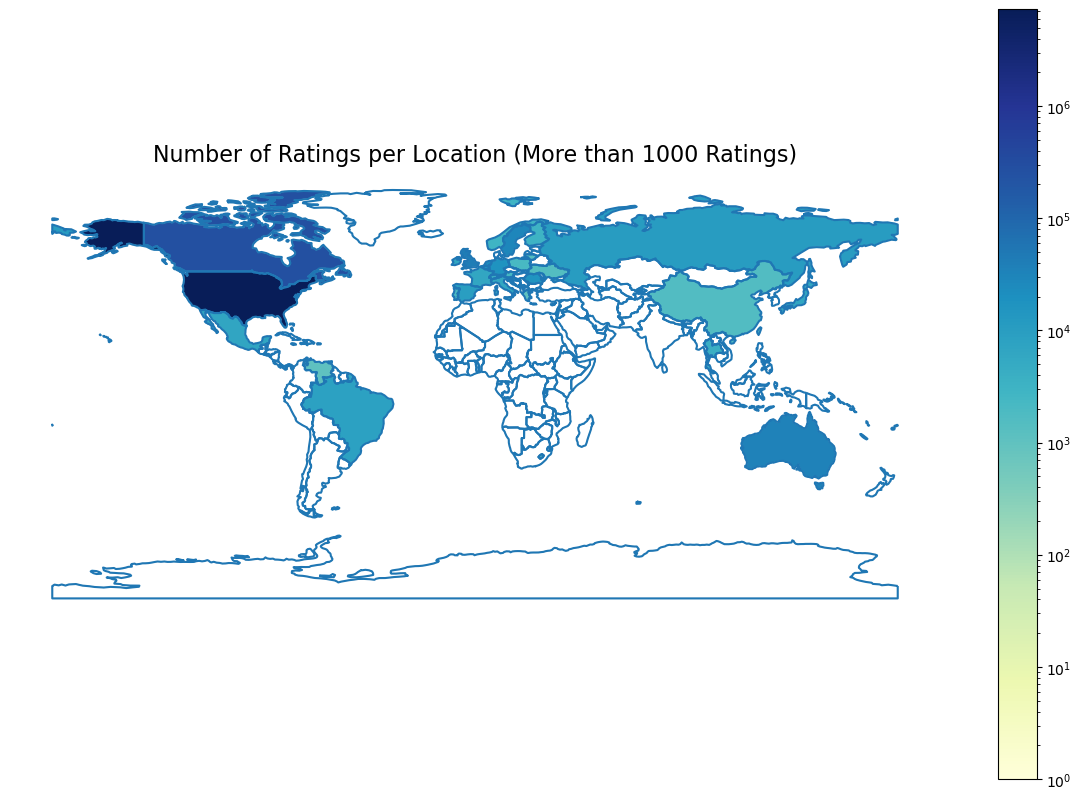

In [4]:
shapefile_path = r'C:\Users\Qrnqult\OneDrive\Documents\GitHub\ADA_project\ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Merge your ratings data with the world GeoDataFrame
merged = world.merge(nbr_ratings_per_location, how='left', left_on='SOVEREIGNT', right_on='cleaned_location')

# Fill NaN values in 'nbr_ratings' with 0 for visualization
merged['nbr_ratings'] = merged['nbr_ratings'].fillna(0)

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax)  # Plot the world boundaries
merged.plot(column='nbr_ratings', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', 
            norm=LogNorm(vmin=1, vmax=merged['nbr_ratings'].max()), legend=True)

# Customizing the plot
ax.set_title('Number of Ratings per Location (More than 1000 Ratings)', fontsize=16)
ax.set_axis_off()  # Turn off the axis
plt.show()

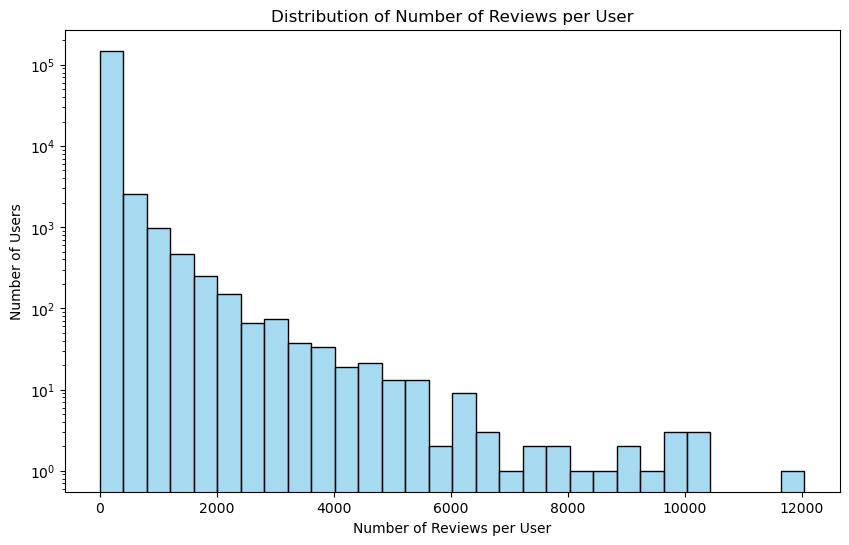

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(ba_users_df['nbr_ratings'], bins=30, kde=False, color="skyblue")  # Adjust bins as needed
plt.xlabel('Number of Reviews per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Reviews per User')
plt.yscale('log')  # Optional: Log scale for better visualization if skewed
plt.show()

**Most drinken beer per location and per year**

In [20]:
users_df_selected = ba_users_df[['user_id', 'location']]
ratings_df_selected = ba_ratings_df[['user_id', 'brewery_id', 'style', 'appearance', 'aroma', 'palate', 'taste', 'date']]

# Merging on 'user_id'
merged_df = pd.merge(users_df_selected, ratings_df_selected, on='user_id', how='inner')

ba_breweries_df.rename(columns={'location': 'brewery_location'}, inplace=True)
ba_breweries_df.rename(columns={'id': 'brewery_id'}, inplace=True)

ba_breweries_selected = ba_breweries_df[['brewery_id', 'brewery_location']]

# Perform the merge on `beer_id`
final_merged_df = pd.merge(merged_df, ba_breweries_selected, on='brewery_id', how='inner')

In [21]:
print(final_merged_df)

                   user_id                   location  brewery_id  \
0           nmann08.184925  United States, Washington       37262   
1           nmann08.184925  United States, Washington       13092   
2           nmann08.184925  United States, Washington         323   
3           nmann08.184925  United States, Washington         323   
4           nmann08.184925  United States, Washington         323   
...                    ...                        ...         ...   
8393027     everman.532342  United States, California       23640   
8393028  justin0001.352175  United States, California       23640   
8393029    kyungsup.982216                        NaN       23640   
8393030      joetex.800347  United States, California       23640   
8393031  alexmatt86.313751  United States, California       23640   

                                       style  appearance  aroma  palate  \
0                            Euro Pale Lager        3.25   2.75    3.25   
1        Extra Specia

In [9]:
# Assuming final_merged_df is your DataFrame
# Get unique styles from the 'style' column
unique_styles = final_merged_df['style'].unique()

# Print the unique styles
print(unique_styles)

['Euro Pale Lager', 'Extra Special / Strong Bitter (ESB)', 'Old Ale', 'English Porter', 'English Strong Ale', ..., 'English Pale Mild Ale', 'Roggenbier', 'Faro', 'Euro Strong Lager', 'Kvass']
Length: 104
Categories (104, object): ['Altbier', 'American Amber / Red Ale', 'American Amber / Red Lager', 'American Barleywine', ..., 'Lambic - Unblended', 'Happoshu', 'Japanese Rice Lager', 'Faro']


In [19]:
macro_group = {
    'IPA': ['American IPA', 'English India Pale Ale (IPA)', 'Belgian IPA', 'American Double / Imperial IPA']
}

In [26]:
final_merged_df['datetime'] = pd.to_datetime(final_merged_df['date'], unit='s')

# Extract the year from the datetime
final_merged_df['year'] = final_merged_df['datetime'].dt.year

def categorize_macro_group(style):
    for key, styles in macro_group.items():
        if style in styles:
            return key
    return 'Other'

final_merged_df['macro_group'] = final_merged_df['style'].apply(categorize_macro_group)

In [27]:
print(final_merged_df)

                   user_id                   location  brewery_id  \
0           nmann08.184925  United States, Washington       37262   
1           nmann08.184925  United States, Washington       13092   
2           nmann08.184925  United States, Washington         323   
3           nmann08.184925  United States, Washington         323   
4           nmann08.184925  United States, Washington         323   
...                    ...                        ...         ...   
8393027     everman.532342  United States, California       23640   
8393028  justin0001.352175  United States, California       23640   
8393029    kyungsup.982216                        NaN       23640   
8393030      joetex.800347  United States, California       23640   
8393031  alexmatt86.313751  United States, California       23640   

                                       style  appearance  aroma  palate  \
0                            Euro Pale Lager        3.25   2.75    3.25   
1        Extra Specia

In [30]:
grouped = final_merged_df.groupby(['year', 'macro_group']).size().reset_index(name='count')

# Group by year to get total counts
total_count_per_year = final_merged_df.groupby('year').size().reset_index(name='total_count')

# Merge the counts with total counts
merged = pd.merge(grouped, total_count_per_year, on='year')

# Calculate the percentage
merged['percentage'] = (merged['count'] / merged['total_count']) * 100

# Filter to show only the macro group 'IPA'
result = merged[merged['macro_group'] == 'IPA'][['year', 'count', 'total_count', 'percentage']]

print(result)

    year   count  total_count  percentage
1   1998      10          134    7.462687
3   1999       6           83    7.228916
5   2000       9          110    8.181818
7   2001     128         1816    7.048458
9   2002    1291        20811    6.203450
11  2003    3922        50512    7.764492
13  2004    6146        62995    9.756330
15  2005    7936        79333   10.003403
17  2006   14252       116197   12.265377
19  2007   17352       128747   13.477596
21  2008   27043       194854   13.878596
23  2009   37902       233253   16.249309
25  2010   46022       270984   16.983291
27  2011   93404       524259   17.816385
29  2012  167917       888491   18.899122
31  2013  284377      1314109   21.640290
33  2014  442169      1883572   23.475025
35  2015  329802      1286137   25.642836
37  2016  261647       924219   28.310065
39  2017  133929       412415   32.474328


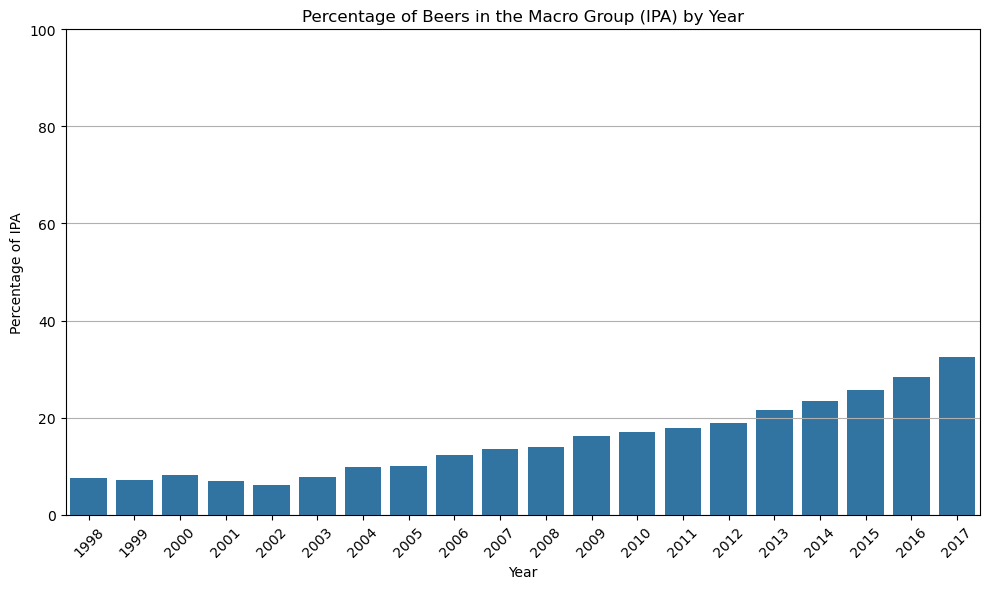

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(data=result, x='year', y='percentage')
plt.title('Percentage of Beers in the Macro Group (IPA) by Year')
plt.xlabel('Year')
plt.ylabel('Percentage of IPA')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100
plt.grid(axis='y')  # Add grid lines for better visualization
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()